In [2]:
import pandas as pd

df = pd.read_csv("crypto_dataset.csv")

df.shape


(72946, 10)

In [3]:
df.columns



Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap',
       'timestamp', 'crypto_name', 'date'],
      dtype='object')

In [4]:

df.head()


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,05-05-2013
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,05-05-2013
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,06-05-2013
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,06-05-2013
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,07-05-2013


In [7]:
df.columns




Index(['open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp',
       'crypto_name', 'date'],
      dtype='object')

In [8]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


In [9]:
df['date'].isnull().sum()


np.int64(0)

In [10]:
df = df.sort_values(by=['crypto_name', 'date'])


In [11]:
df.isnull().sum()


,0
open,0
high,0
low,0
close,0
volume,0
marketCap,0
timestamp,0
crypto_name,0
date,0


In [12]:
import numpy as np

df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()


In [13]:
df['volatility_7d'] = (
    df.groupby('crypto_name')['daily_return']
      .rolling(window=7)
      .std()
      .reset_index(level=0, drop=True)
)


In [14]:
df[['crypto_name', 'date', 'daily_return', 'volatility_7d']].head(10)


,crypto_name,date,daily_return,volatility_7d
44644,Aave,2020-10-02,NaN,NaN
44709,Aave,2020-10-03,101.892809,NaN
44780,Aave,2020-10-04,-0.008964,NaN
44826,Aave,2020-10-05,0.010331,NaN
44843,Aave,2020-10-06,-0.203266,NaN
44901,Aave,2020-10-07,-0.054659,NaN
44938,Aave,2020-10-08,0.091819,NaN
45010,Aave,2020-10-09,0.069766,38.517966
45028,Aave,2020-10-10,0.049468,0.099951
45120,Aave,2020-10-11,0.010726,0.100147


In [36]:
#Price-based features
df['hl_spread'] = df['high'] - df['low']
df['co_spread'] = df['close'] - df['open']


In [37]:
# Liquidity feature
df['liquidity_ratio'] = df['volume'] / (df['marketCap'] + 1)


In [38]:
df[['hl_spread', 'co_spread', 'liquidity_ratio']].head() #check


,hl_spread,co_spread,liquidity_ratio
44644,0.516571,0.516571,0.000000
44709,64.782137,52.627651,0.000000
44780,4.381366,-0.504823,0.000000
44826,5.324459,0.544208,0.000000
44843,12.667692,-10.890371,0.008211


In [39]:
#NaN count check
df.isnull().sum()


,0
open,0
high,0
low,0
close,0
volume,0
marketCap,0
timestamp,0
crypto_name,0
date,0
daily_return,56


In [40]:
df = df.dropna() #NaN rows drop


In [41]:
df.isnull().sum() # confirming


,0
open,0
high,0
low,0
close,0
volume,0
marketCap,0
timestamp,0
crypto_name,0
date,0
daily_return,0


In [42]:
y = df['volatility_7d'] #Target variable (confirm)


In [43]:
#Feature set (X)

X = df[
    ['open', 'high', 'low', 'close',
     'volume', 'marketCap',
     'hl_spread', 'co_spread',
     'liquidity_ratio']
]


In [44]:
#Train–Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)
#Shuffling was disabled during train-test split to preserve temporal dependencies in time-series data

In [45]:
#Shape check
X_train.shape, X_test.shape


((56066, 9), (14017, 9))

In [46]:
#Linear Regression (Baseline)
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
#Random Forest Regressor

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [48]:
#Evaluation function

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"{name} Results:")
    print("RMSE:", rmse)
    print("MAE :", mae)
    print("R²  :", r2)
    print("-"*30)


In [49]:
#Evaluate both models

evaluate_model(lr, "Linear Regression")
evaluate_model(rf, "Random Forest")
#Random Forest achieved lower error metrics compared to Linear Regression, indicating better performance in capturing market volatility patterns.


Linear Regression Results:
RMSE: 0.054918689670273364
MAE : 0.0391441925340979
R²  : -0.39944819608096416
------------------------------
Random Forest Results:
RMSE: 0.04018509291558146
MAE : 0.025980619190957257
R²  : 0.25071602051675246
------------------------------


In [50]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance


,0
low,0.188671
hl_spread,0.150698
volume,0.130545
high,0.130201
liquidity_ratio,0.124180
open,0.112813
marketCap,0.073134
co_spread,0.053332
close,0.036426


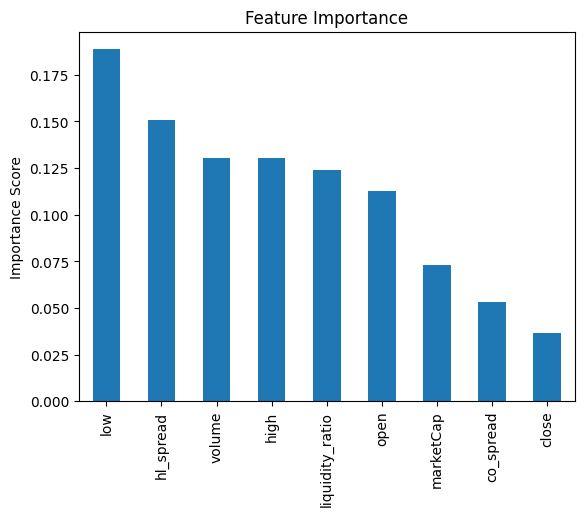

In [51]:
import matplotlib.pyplot as plt

feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.show()


In [52]:
import joblib

# Save trained Random Forest model
joblib.dump(rf, "rf_volatility_model.pkl") #The trained Random Forest model was serialized using joblib for deployment.


['rf_volatility_model.pkl']